In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 9)

model = model.to(device)

model.load_state_dict(torch.load("resnet-fullres-model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [2]:
image_size = 1000

data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Modified-Testing': transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/bradyjohnsen/Desktop/LMIC Internship/BodyPartProject'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Modified-Testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=270,
                                              shuffle=True, num_workers=4)
               for x in ['Training', 'Modified-Testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Modified-Testing']}
class_names = image_datasets['Training'].classes

In [3]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from torch.nn import functional as F
from torch.autograd import Variable


#confusion matrix heatmap
y_score = []
y_test = []

# iterate over test data
for inputs, labels in dataloaders['Modified-Testing']:
        for i in range(len(inputs)):
            prediction_var = Variable((inputs[i].unsqueeze(0)).cpu(), requires_grad=True)
            model.eval()
            output = model(prediction_var) # Feed Network

            pred_probabilities = F.softmax(output, dim=1).data.squeeze()
            y_score.append(pred_probabilities) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_test.extend(labels) # Save Truth



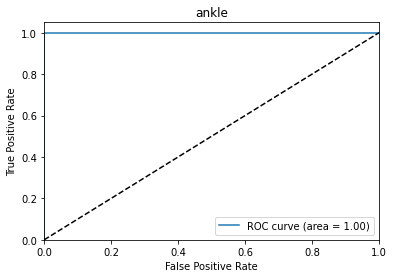

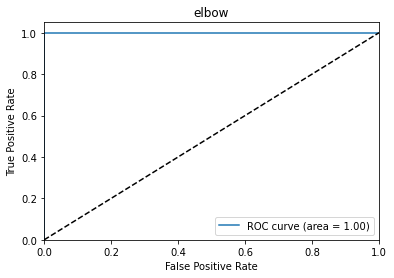

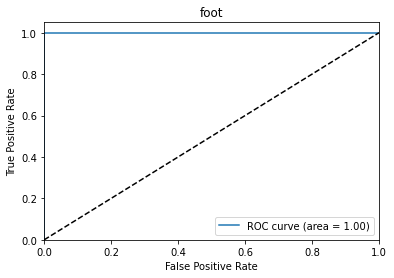

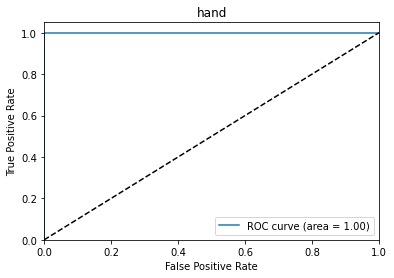

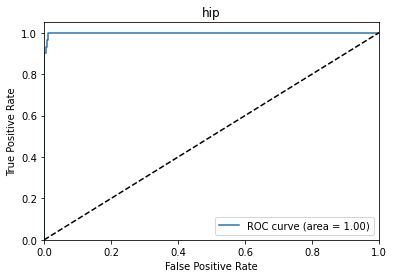

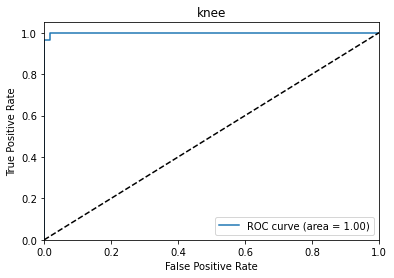

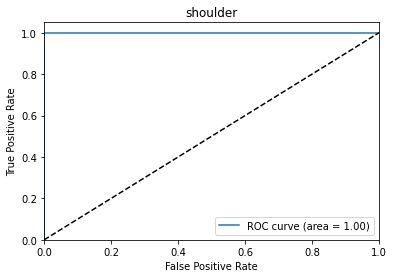

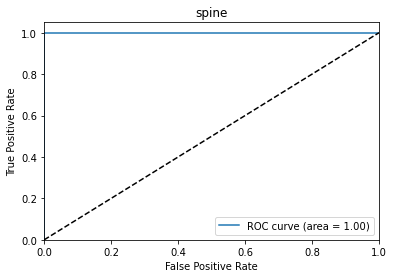

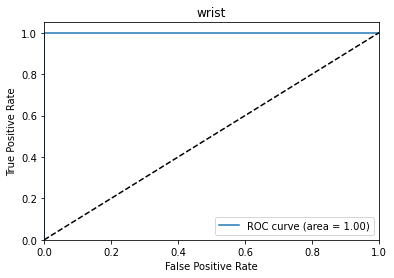

In [4]:
y_test = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8])
n_classes = 9

for i in range(len(y_score)):
    y_score[i] = y_score[i].tolist()
    y_score[i] = np.array(y_score[i])


y_score = np.array(y_score)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(class_names[i])
    plt.legend(loc="lower right")
    plt.show()